In [1]:
import sys
sys.path.append("/PATH/TO/SCE-SRLDM/ldm/autoencoder/")

In [2]:
from engine import train_l2_Codebook, train
from vqvae import VQVAE
from discriminator import Discriminator
import torchvision
import torchvision.transforms as t
import torch
import torch.utils.data as data
from utils import to_image, get_comparison

/home/016854656/miniconda3/envs/torch/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
VQVAE_LR = 1e-4
DISC_LR = 3e-4
BATCH_SIZE=32

## Dataset Setup

In [4]:
import datasets
import os
root = "/PATH/TO/data/celebahq"

ds = datasets.Dataset.from_dict({"image":[root + "/" + item for item in os.listdir(root)]}).cast_column("image", datasets.Image()).with_format("torch")
ds

Dataset({
    features: ['image'],
    num_rows: 30000
})

In [5]:
transform = t.Compose(
    [
        t.PILToTensor(),
        # normalize to -.5, .5
        t.Lambda(lambda x: (x.to(torch.float32) / 255) - 0.5)
    ]
)
def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("RGB")) for image in examples['image']]
    del examples['image']
    return examples
ds.set_transform(transforms)

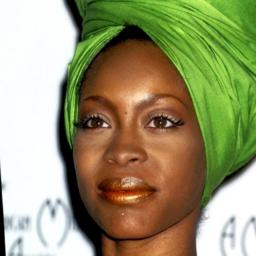

In [6]:
to_image(ds[0]['pixel_values'])

In [7]:
dl = data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)

In [8]:
next(iter(dl))['pixel_values'].shape

torch.Size([32, 3, 256, 256])

## Modeling

In [9]:
# instantiate models
vqvae = VQVAE(input_shape=(32, 32), n_hidden=256, n_layers=3, kernel_size=8, num_embeddings=512, embedding_dim=4, n_residuals=2, residual_multiplier=.25)
# vqvae.load_state_dict(torch.load("vqvae.pt"))
vqvae = vqvae.cuda()


In [10]:
# instantiate optimizers
vqvae_optim = torch.optim.AdamW(vqvae.parameters(), VQVAE_LR)
# vqvae_optim.load_state_dict(torch.load("vqvae_optim.pt"))


In [11]:
print(vqvae)

VQVAE(
  (encoder): Encoder(
    (units): ModuleList(
      (0): DownUnit(
        (unit): Sequential(
          (0): Conv2d(3, 64, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
          (1): GELU(approximate='none')
          (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): DownUnit(
        (unit): Sequential(
          (0): Conv2d(64, 128, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
          (1): GELU(approximate='none')
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): DownUnit(
        (unit): Sequential(
          (0): Conv2d(128, 256, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3))
          (1): GELU(approximate='none')
          (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
  )
  (vq): VectorQuantizer(
    (codebook): Embedding(512, 4)
  )
  (decoder): Decoder

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(vqvae)

13792842

## Training

In [ ]:
# train(5, dl, vqvae, vqvae_optim, disc, disc_optim, "cuda")
train_l2_Codebook(3, dl, vqvae, vqvae_optim, "cuda", lambda b: b[0])

In [15]:
vqvae = vqvae.eval()


In [16]:
torch.save(vqvae.state_dict(), "vqvae_celeba.pt")
torch.save(vqvae_optim.state_dict(), "vqvae_optim_celeba.pt")

/home/016854656/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,


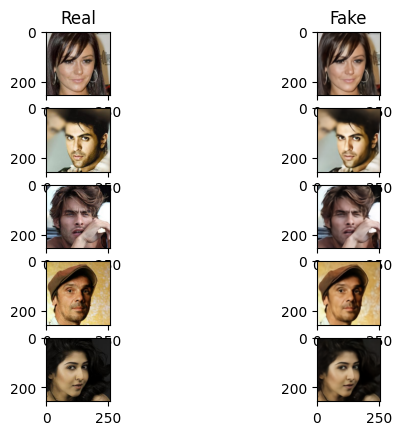

In [17]:
get_comparison(5, ds, vqvae, lambda b: b['pixel_values'])

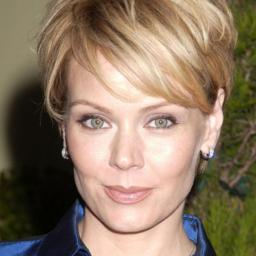

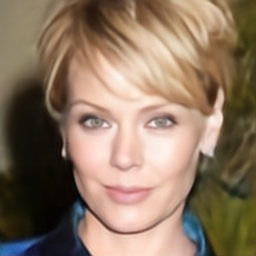

In [21]:
import random
k = random.randint(0, len(ds))
real = to_image(ds[k]['pixel_values'])
with torch.no_grad():
    reconstructed = to_image(vqvae(ds[k]['pixel_values'].unsqueeze(0).cuda())[0][0].cpu())
display(real, reconstructed)